In [5]:
from SimPEG import *
from simpegPF import BaseMag
from scipy.constants import mu_0
from simpegPF.MagAnalytics import spheremodel, CongruousMagBC
from simpegPF.Magnetics import MagneticsDiffSecondary, MagneticsDiffSecondaryInv
# import SeogiUtils as SeUtils
# import simpegEM.Utils.Solver.Mumps as Mumps
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Mag Inversion

## Step1: Generating mesh

In [5]:
cs = 25.
hxind = [(cs,5,-1.3), (cs, 31),(cs,5,1.3)]
hyind = [(cs,5,-1.3), (cs, 31),(cs,5,1.3)]
hzind = [(cs,5,-1.3), (cs, 30),(cs,5,1.3)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

## Step2: Generating Model: Use Combo model

### Here we combined $\mu$ model$^1$, Depth model$^2$ and Active model$^3$

In [6]:
chibkg = 1e-5
chiblk = 0.1
chi = np.ones(mesh.nC)*chibkg
sph_ind = spheremodel(mesh, 0., 0., -150., 80)
chi[sph_ind] = chiblk
active = mesh.gridCC[:,2]<0
actMap = Maps.ActiveCells(mesh, active, chibkg)
dweight = np.ones(mesh.nC)
dweight[active] = (1/abs(mesh.gridCC[active, 2]-13.)**1.5)
baseMap = BaseMag.BaseMagMap(mesh)
depthMap = BaseMag.WeightMap(mesh, dweight)
dmap = baseMap*actMap
rmap = depthMap*actMap
model = (chi)[active]

In [12]:
sph_ind_ini = spheremodel(mesh, 0., 0., -200., 150)

In [8]:
chi_ini = np.ones_like(chi)*chibkg
chi_ini[sph_ind_ini] = chiblk*0.1

(-500, 0)

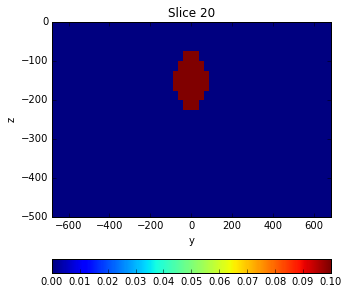

In [15]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
dat1 = mesh.plotSlice(chi, ax = ax, normal = 'X')
plt.colorbar(dat1[0], orientation="horizontal", ax = ax)
ax.set_ylim(-500, 0)

In [16]:
print model.shape
print chi.shape

(33620L,)
(67240L,)


## Step3: Generating Data

In [17]:
survey = BaseMag.BaseMagSurvey()
const = 20
Inc = 90.
Dec = 0.
Btot = 51000
survey.setBackgroundField(Inc, Dec, Btot)


In [ ]:
xr = np.linspace(-300, 300, 81)
yr = np.linspace(-300, 300, 81)
X, Y = np.meshgrid(xr, yr)
Z = np.ones((xr.size, yr.size))*(0.)
rxLoc = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
survey.rxLoc = rxLoc
prob = MagneticsDiffSecondary(mesh, mapping = dmap)
prob.pair(survey)
prob.Solver = Utils.SolverUtils.SolverWrapD(Mumps, factorize=True)

In [7]:
dsyn = survey.dpred(model)

In [8]:
survey.dtrue = Utils.mkvc(dsyn)
std = 0.05
noise = std*abs(survey.dtrue)*np.random.randn(*survey.dtrue.shape)
survey.dobs = survey.dtrue+noise
survey.std = survey.dobs*0 + std

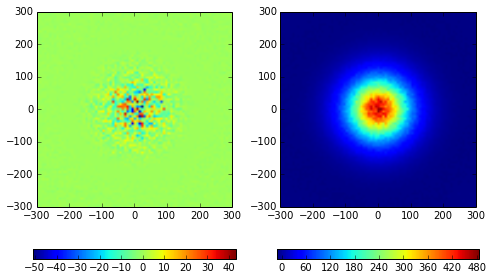

In [9]:
fig, ax = plt.subplots(1,2, figsize = (8,5) )
dat = ax[0].imshow(np.reshape(noise, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)])
plt.colorbar(dat, ax = ax[0], orientation="horizontal")
dat2 = ax[1].imshow(np.reshape(survey.dobs, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)])
plt.colorbar(dat2, ax = ax[1], orientation="horizontal")
plt.show()

In [36]:
# m0 = (1e-5*np.ones(mesh.nC))[active]
m0 = chi_ini[active]/dweight[active] 
dmisfit = DataMisfit.l2_DataMisfit(survey)
valmin = abs(survey.dobs).max()
dmisfit.Wd = 1/(np.ones(survey.dobs.size)*valmin)

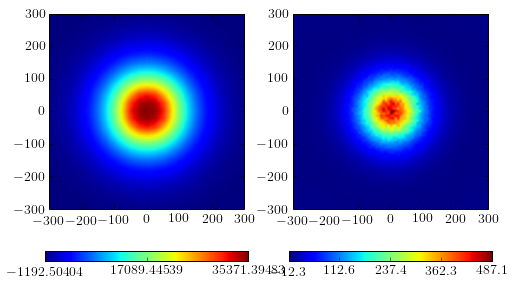

In [37]:
d_ini = survey.dpred(m0)
fig, ax = plt.subplots(1,2, figsize = (8,5) )
dat1 = ax[0].imshow(np.reshape(d_ini, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)])
vmin = d_ini.min()
vmax = d_ini.max()
plt.colorbar(dat1, ax = ax[0], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 3)], format = FormatStrFormatter('$%5.5f$'))
dat2 = ax[1].imshow(np.reshape(survey.dobs, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)])
vmin = survey.dobs.min()
vmax = survey.dobs.max()
plt.colorbar(dat2, ax = ax[1], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)])
plt.show()

In [40]:
reg = Regularization.Tikhonov(mesh, mapping = rmap)
opt = Optimization.ProjectedGNCG(maxIter = 30)
opt.lower = 1e-10
opt.maxIterLS = 50
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=8, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**0)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest])
opt.tolG = 1e-20
opt.eps = 1e-20
reg.alpha_s = 1e-9
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.1
opt.remember('xc')

In [41]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0 -8.78e+04  1.08e+06  2.70e-01  1.06e+06    1.38e+05      0              
   1 -8.78e+04  3.89e+05  1.52e+09 -1.34e+14    1.57e+08      0              
   2 -1.10e+04  2.49e+05  1.52e+09 -1.67e+13    1.96e+07     15   Skip BFGS  
   3 -1.10e+04  2.49e+05  1.52e+09 -1.67e+13    1.96e+07     19   Skip BFGS  
   4 -1.37e+03  2.49e+05  1.52e+09 -2.09e+12    2.45e+06     19   Skip BFGS  


KeyboardInterrupt: 

In [20]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :       30
  ProjectedGNCG.doEndIteration            :       30
  ProjectedGNCG.doStartIteration          :       31
  ProjectedGNCG.projection                :      394
  ProjectedGNCG.scaleSearchDirection      :       30

Times:                                        mean      sum
  MagneticsDiffSecondary.Jtvec            : 3.10e-01, 5.64e+01,  182x
  MagneticsDiffSecondary.Jtvec_approx     : 3.48e-01, 5.26e+01,  151x
  MagneticsDiffSecondary.Jvec             : 3.48e-01, 5.26e+01,  151x
  MagneticsDiffSecondary.Jvec_approx      : 3.48e-01, 5.26e+01,  151x
  ProjectedGNCG.findSearchDirection       : 3.66e+00, 1.10e+02,   30x
  ProjectedGNCG.minimize                  : 2.57e+02, 2.57e+02,    1x
  ProjectedGNCG.modifySearchDirection     : 4.71e+00, 1.41e+02,   30x


In [21]:
from JSAnimation import IPython_display
from matplotlib import animation
from SimPEG import *

fig, ax = subplots(1,2, figsize = (16, 5))
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Depth (m)')
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Depth (m)')


def animate(i_id):
    indx = 18
    temp = dmap*(xc[i_id])
    minval = (temp).min()
    maxval = (temp).max()
    
    frame1 = mesh.plotSlice(temp, vType='CC', ind=indx, normal='X',ax = ax[1], grid=False, gridOpts={'color':'b','lw':0.3, 'alpha':0.5}, )
    frame2 = mesh.plotSlice(chi, vType='CC', ind=indx, normal='X',ax = ax[0], grid=False, gridOpts={'color':'b','lw':0.3, 'alpha':0.5}, );
    ax[0].set_title('True model', fontsize = 16)
    ax[1].set_title('Estimated model at iteration = ' + str(i_id+1), fontsize = 16)
    ax[0].set_ylim(-500, 0)
    ax[1].set_ylim(-500, 0)
    return frame1[0]

animation.FuncAnimation(fig, animate, frames=10, interval=40, blit=True)

In [16]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'text.usetex': True, 'font.family': 'arial'})

/usr/local/lib/python2.7/dist-packages/matplotlib/lines.py:503: RuntimeWarning: invalid value encountered in greater_equal
  return np.alltrue(x[1:] - x[0:-1] >= 0)


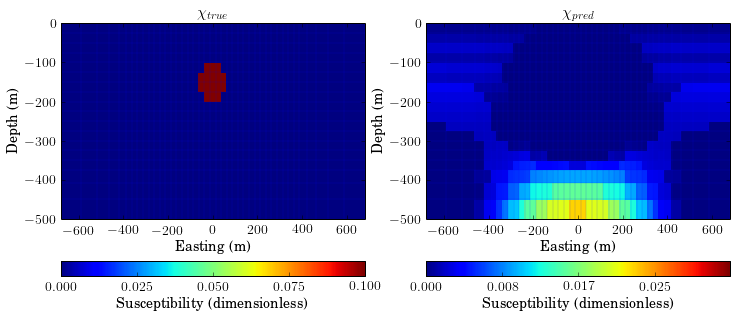

In [17]:
indx = 18
iteration = 9
fig, axes = subplots(1,2, figsize = (12, 5))
vmin = chi.min()
vmax = chi.max()
ps1 = mesh.plotSlice(chi, vType='CC', ind=indx, normal='X',ax = axes[0], grid=True, gridOpts={'color':'b','lw':0.3, 'alpha':0.5});
axes[0].set_title('$\chi_{true}$', fontsize = 16)
axes[0].set_ylim(-500, 0.)
cb1 = colorbar(ps1[0], ax =  axes[0], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)], format = FormatStrFormatter('$%5.3f$'))
axes[0].set_xlabel('Easting (m)')
axes[0].set_ylabel('Depth (m)')

vmin = (actMap*xc[iteration]).min()
vmax = (actMap*xc[iteration]).max()
ps2 = mesh.plotSlice(actMap*xc[iteration], vType='CC', ind=indx, normal='X', ax = axes[1], grid=True, gridOpts={'color':'b','lw':0.3, 'alpha':0.5});
axes[1].set_title('$\chi_{pred}$', fontsize = 16)
axes[1].set_ylim(-500, 0.)
cb2 = colorbar(ps2[0], ax =  axes[1], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)], format = FormatStrFormatter('$%5.3f$'))
cb1.set_label('Susceptibility (dimensionless)')
cb2.set_label('Susceptibility (dimensionless)')
axes[1].set_xlabel('Easting (m)')
axes[1].set_ylabel('Depth (m)')
fig.savefig('model.png', dpi = 200)

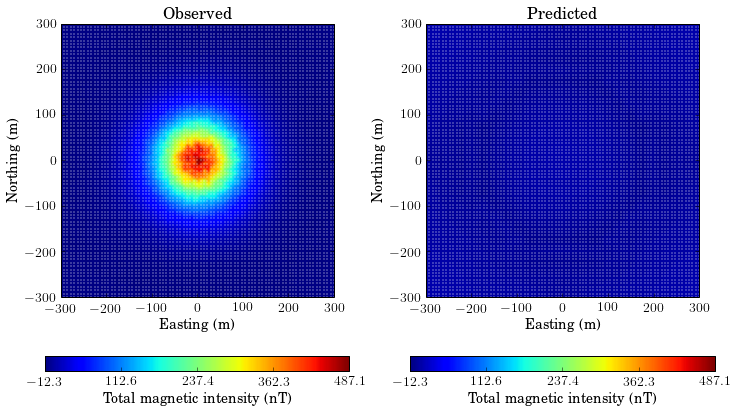

In [18]:
dpred_xc = survey.dpred(xc[iteration])
fig, ax = plt.subplots(1,2, figsize = (12,7) )
vmin = survey.dobs.min()
vmax = survey.dobs.max()
dat2 = ax[0].imshow(np.reshape(survey.dobs, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)], vmin = vmin, vmax = vmax)
cb1 = plt.colorbar(dat2, ax = ax[0], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)])
dat = ax[1].imshow(np.reshape(dpred_xc, (xr.size, yr.size), order='F'), extent=[min(xr), max(xr), min(yr), max(yr)], vmin = vmin, vmax = vmax)
cb2 = plt.colorbar(dat, ax = ax[1], orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)])
ax[0].plot(rxLoc[:,0],rxLoc[:,1],'w.', ms=1)
ax[1].plot(rxLoc[:,0],rxLoc[:,1],'w.', ms=1)
ax[0].set_title('Observed', fontsize = 16)
ax[1].set_title('Predicted', fontsize = 16)
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')
ax[1].set_xlabel('Easting (m)')
ax[1].set_ylabel('Northing (m)')
cb1.set_label('Total magnetic intensity (nT)')
cb2.set_label('Total magnetic intensity (nT)')
fig.savefig('obspred.png', dpi = 200)